### This part will be a clean data from columns by raw_data_with_labels and create a first model

In [126]:
import pandas as pd
import numpy as np
import re
import time

import bs4 as bs4
import json

import glob
import tqdm

pd.set_option("max.columns", 200)
pd.set_option("max.rows", 200)


%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [127]:
df = pd.read_csv('raw_data_with_labels.csv', index_col=0)
df = df[df['y'].notnull()]
df.shape

(498, 16)

In [128]:
((df['y'].value_counts()/183)*100)  ## percentual of negative and positive

0.0    235.519126
1.0     36.612022
Name: y, dtype: float64

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [130]:
df_clean = pd.DataFrame(index=df.index)

## Data Cleaner
    First of all chose the columns will be a possible feature
    Data cleaner with regex from python "Import re"
       create a new column with data get with re
       transform string to datetime

In [131]:
df.shape

(498, 16)

In [132]:
# To see how can we get the data in column watch-time-text, because, has a text and date
df.head(2)

,watch-title,y,watch-view-count,watch-time-text,content_watch-info-tag-list,watch7-headline,watch7-user-header,watch8-sentiment-actions,og:image,og:image:width,og:image:height,og:description,og:video:width,og:video:height,og:video:tag,channel_link_0
0,How to Become A Machine Learning Engineer | Ho...,0.0,28.028 visualizações,Publicado em 3 de set. de 2018,Educação,#MachineLearningAlgorithms #Datasciencecourse ...,Simplilearn\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nCarre...,28.028 visualizações\n\n\n\n\n\n\n\n601\n\nGos...,https://i.ytimg.com/vi/-5hEYRt8JE0/maxresdefau...,1280.0,720.0,"This video on ""How to become a Machine Learnin...",1280.0,720.0,simplilearn,/channel/UCsvqVGtbbyHaMoevxPAq9Fg
1,BLOOPERS - Behind The Scenes. | DATA SCIENCE x...,0.0,1.131 visualizações,Publicado em 16 de nov. de 2018,Pessoas e blogs,#FAIL #insidezalando\n\n\n\n BLOOPERS - Beh...,Inside Zalando\n\n\n\n\n\n\n\n\n\n\n\n\n\nCarr...,1.131 visualizações\n\n\n\n\n\n\n\n20\n\nGosto...,https://i.ytimg.com/vi/-7GiiT0yEyk/maxresdefau...,1280.0,720.0,#FAIL :) Have fun - and join our teams: https:...,1280.0,720.0,employer branding,/channel/UCTPin8TK-KRSI9zo9FoxG0g


##### possible features to convert
    [watch-time-text], [watch-view-count], [watch-title], [watch8-sentiment-actions]

In [133]:
# regex was a better way to get data
# we need input the number 0 because a date format
clean_date = df['watch-time-text'].str.extract(r"(\d+) de ([a-z]+)\. de (\d+)")
clean_date[0] = clean_date[0].map(lambda x: "0"+x[0] if len(str(x)) == 1 else x) 

# changed the portuguese to english format with capital letter, to converter
month_map = {
    'jan':'Jan',
    'fev':'Feb',
    'mar':'Mar',
    'abr':'Apr',
    'mai':'May',
    'jun':'Jun',
    'jul':'Jul',
    'ago':'Aug',
    'set':'Sep',
    'out':'Oct',
    'nov':'Nov',
    'dez':'Dec'}

clean_date[1] = clean_date[1].map(month_map)
clean_date.dropna(axis=0, inplace=True)
# join the three columns to only one column to convert
clean_date = clean_date.apply(lambda x: " ".join(x), axis=1)
# we have two options here, change the order of column or 
# just input format at datetime function, it was better
df_clean['date'] = pd.to_datetime(clean_date, format='%d %b %Y')

In [134]:
# extract with regular expression getting only number and replace dot to empt
view = df['watch-view-count'].str.extract(r'(\d+\.?\d*\.?\d*)', expand=False)
view = view.str.replace('.', '').fillna(0).astype(int)

In [135]:
df_clean['views'] = view  # get the views and create new column
df_clean.head()

,date,views
0,2018-09-03,28028
1,2018-11-16,1131
2,2019-05-02,1816
3,2019-08-13,1171
4,2018-11-30,1228


## Features
#### Will be choice only two or three features to test the first model

In [136]:
features = pd.DataFrame(index=df.index)
y = df['y'].copy()

In [137]:
# for while to efect of data comparation left the same date to compare models
# when you chose the model change to this
# features['pub_time'] = (pd.datetime.now() - df_clean['date'])/np.timedelta64(1, 'D') 
features['pub_time'] = (pd.to_datetime('2020-02-23') - df_clean['date'])/np.timedelta64(1, 'D')
features['views'] = df_clean['views']
features['views_per_day'] = features['views'] / features['pub_time']

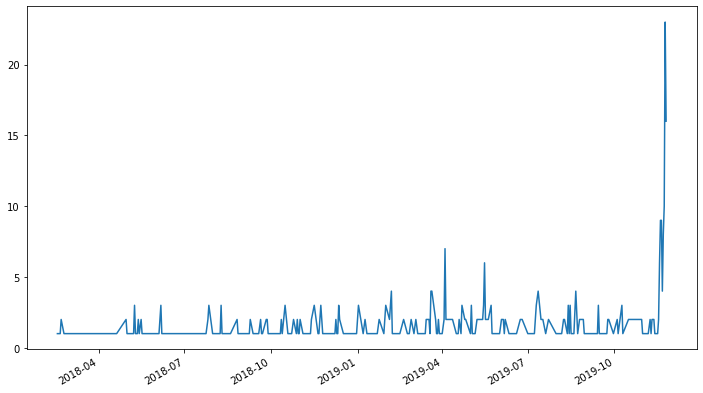

In [138]:
df_clean['date'].value_counts().plot(figsize=(12, 7))
# as you can see, the counts numbers of date are instable, and not be able to use
# than we will drop this column from features and left the views per days
# it's more confiable

In [180]:
features = features.drop('pub_time', axis=1)

# Model 01

In [181]:
from sklearn.tree import DecisionTreeClassifier 

In [182]:
# divided around 50%, not exatly, but close that
Xtrain, Xval = features[df_clean['date'] <= '2019-04-30'], features[df_clean['date'] > '2019-04-30']
ytrain, yval = y[df_clean['date'] <= '2019-04-30'], y[df_clean['date'] > '2019-04-30']
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((258, 2), (240, 2), (258,), (240,))

In [206]:
mdl = DecisionTreeClassifier(random_state=0, max_depth=2, class_weight='balanced')
mdl.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [207]:
prob = mdl.predict_proba(Xval)[:, 1]

In [208]:
target = mdl.predict(Xval)

In [209]:
from sklearn.metrics import average_precision_score, f1_score, roc_auc_score

In [210]:
average_precision_score(yval, prob)

0.1303966433276778

In [211]:
f1_score(yval, target)

0.21917808219178087

In [212]:
roc_auc_score(yval, target)

0.536525576074522

In [213]:
roc_auc_score(yval, prob)


0.53374734433731

In [214]:
from sklearn.tree import plot_tree

In [215]:
Xtrain.columns

Index(['views', 'views_per_day'], dtype='object')

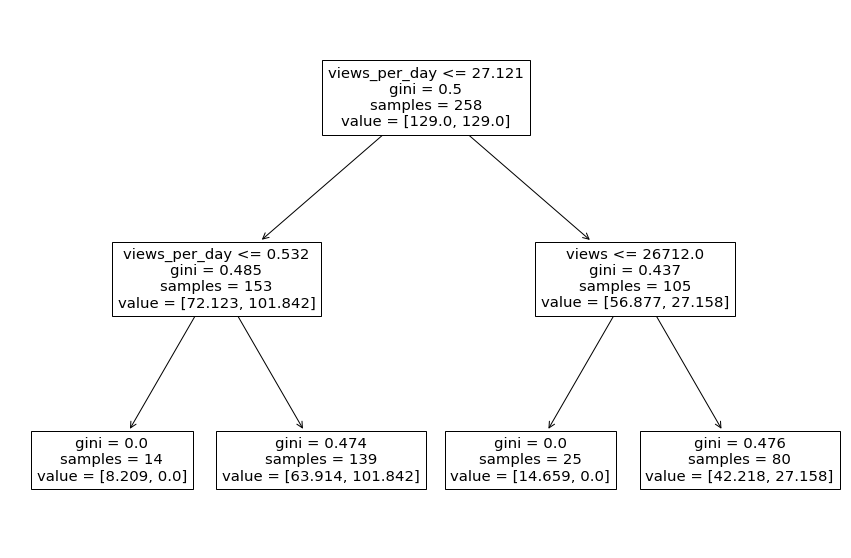

In [216]:
fig, ax = pylab.subplots(1,1, figsize=(15,10))
plot_tree(mdl, ax=ax, feature_names=Xtrain.columns)
#plt.savefig('tree', dpi=150)
plt.show()